In [1]:
import pyBach
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<H1>Scraping Bachelor(ette) Episode and Reddit Data</H1>
pyBach is a collection of functions that allows for scraping of bachelor and bachelorette data from Wikipedia and Reddit
<ol>
    <li>First scrape last 5 season of The Bachelor and The Bachelorette into a pandas dataframe</li>
    <li>Join all individual dataframes into one large dataframe</li>

In [2]:
dfList = []
bachSeasons = range(19,24)
etteSeasons = range(10,15)

for bachSeason in bachSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(bachSeason))

for etteSeason in etteSeasons:
    dfList.append(pyBach.scrapeWikiEpiTable(etteSeason, show='bachelorette'))

df = pd.concat(dfList)

The dataframe contains the following columns:

In [3]:
print(df.columns.values)

['no.overall' 'no. inseason' 'title' 'original air date'
 'u.s. viewers(millions)' 'description' 'posix time' 'show' 'season']


In [4]:
df = pyBach.appendStartTime(df) #default value is 6 days prior to episode airdate
df = pyBach.appendEndTime(df) #default value 0 days

In [5]:
df.head()

,no.overall,no. inseason,title,original air date,u.s. viewers(millions),description,posix time,show,season,startEpoch,endEpoch
0,182,1,"""season premiere: limo arrivals""","january 5, 2015 (2015-01-05)",7.76,\nthe first hour of the episode consists of a ...,1420434000,bachelor,19,1419933600,1420452000
1,183,2,"""week 2: tractor race""","january 12, 2015 (2015-01-12)",6.48,\nkimberly convinced chris to give her another...,1421038800,bachelor,19,1420538400,1421056800
2,184,3,"""week 3: guest host jimmy kimmel""","january 19, 2015 (2015-01-19)",7.61,\nthe episode starts with jimmy kimmel surpris...,1421643600,bachelor,19,1421143200,1421661600
3,185,4,"""week 4: camping""","january 26, 2015 (2015-01-26)",7.95,\nthe episode begins with chris harrison enter...,1422248400,bachelor,19,1421748000,1422266400
4,186,5,"""week 5: santa fe""","february 2, 2015 (2015-02-02)",8.45,\nfirst one-on-one date: carly. chris takes ca...,1422853200,bachelor,19,1422352800,1422871200


<H1>Bachelor and Bachelorette Views per Season</H1>
Since the goal of this analysis is to predict if a show will have high ratings based on the previous weeks Reddit posts, we first need to determine if we need to correct for any overall trends.

Since the after the final rose and (wo)men tell all are a different format, lets filter them out of our dataframe

In [6]:
df = pyBach.filterData(df)

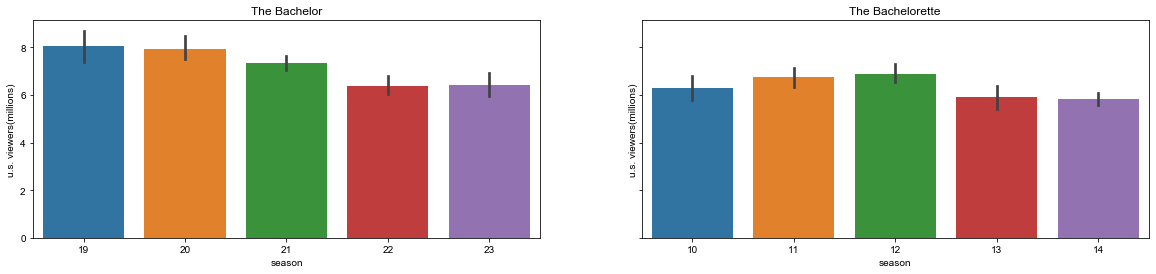

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_figwidth(20)
dfBach = df[df['show'] == 'bachelor']
dfEtte = df[df['show'] == 'bachelorette']
sns.barplot(x=dfBach['season'], y=dfBach['u.s. viewers(millions)'], ax=ax1, ci=95)
sns.barplot(x=dfEtte['season'], y=dfEtte['u.s. viewers(millions)'], ax=ax2, ci=95)
ax1.set_title('The Bachelor')
ax2.set_title('The Bachelorette')

sns.set(style='whitegrid')


In [8]:
#Run a one-way anova on views to be sure
import scipy.stats as stats

f, p = stats.f_oneway(*[dfBach.loc[dfBach.season == x, 'u.s. viewers(millions)'] for x in range(19,24)])
print('The Bachelor Season''s one-way ANOVA P-value is:' + str(p) + '\n')
f, p = stats.f_oneway(*[dfEtte.loc[dfEtte.season == x, 'u.s. viewers(millions)'] for x in range(10,15)])
print('The Bachelorette Season''s one-way ANOVA P-Value is:' + str(p) + '\n')

The Bachelor Seasons one-way ANOVA P-value is:1.0999654630689486e-05

The Bachelorette Seasons one-way ANOVA P-Value is:0.0033698860657416156



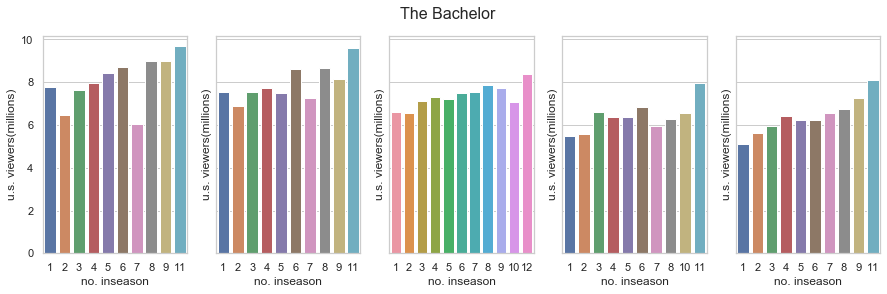

In [9]:
fig, axes = plt.subplots(ncols=5, sharey=True)
fig.set_figwidth(15)
fig.suptitle("The Bachelor", fontsize=16)
idx = 0
for subAx in axes:
    sns.barplot(x=dfBach.loc[dfBach.season == bachSeasons[idx], 'no. inseason'], y=dfBach.loc[dfBach.season == bachSeasons[idx], 'u.s. viewers(millions)'], ax=subAx)
    idx = idx + 1
    

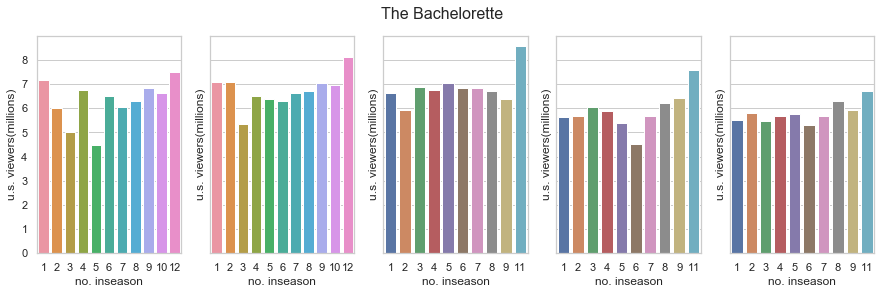

In [10]:
fig, axes = plt.subplots(ncols=5, sharey=True)
fig.set_figwidth(15)
fig.suptitle("The Bachelorette", fontsize=16)
idx = 0
for subAx in axes:
    sns.barplot(x=dfEtte.loc[dfEtte.season == etteSeasons[idx], 'no. inseason'], y=dfEtte.loc[dfEtte.season == etteSeasons[idx], 'u.s. viewers(millions)'], ax=subAx)
    idx = idx + 1

To maximize the possibility of detecting a difference in social media buzz, I am going to limit my initial analysis to only the worse performing and best performing episodes of each season.

In [11]:
# normalize each episode's viewer number by the season finale
df.loc[:, 'norm views'] = pd.Series([0]*df.shape[0])
for showStr in ['bachelor', 'bachelorette']:
    if showStr == 'bachelor':
        for season in bachSeasons:
            df.loc[
                (df.season==season) & (df.show==showStr),'norm views'] = df.loc[(df.season==season) & (df.show==showStr), 'u.s. viewers(millions)']\
                /df.loc[(df.season==season) & (df.show==showStr), 'u.s. viewers(millions)'].max()
    else:
        for season in etteSeasons:
            df.loc[
                (df.season==season) & (df.show==showStr), 'norm views'] = df.loc[(df.season==season) & (df.show==showStr), 'u.s. viewers(millions)']\
            /df.loc[(df.season==season) & (df.show==showStr), 'u.s. viewers(millions)'].max()

In [12]:
# Remove all the season finales whose norm views are one
dfFinless = df.loc[~(df['norm views']==1),:]

In [13]:
# pull out the largest norm views for each season of each show
minList = []
maxList = []
for showStr in ['bachelor', 'bachelorette']:
    if showStr == 'bachelor':
        for season in bachSeasons:
            minValue = dfFinless.loc[(dfFinless.season == season) & (dfFinless.show==showStr), 'norm views'].min()
            tempMin = dfFinless.loc[(dfFinless.season==season) & (dfFinless.show==showStr) & (dfFinless['norm views']==minValue),:]
            # we only want ONE min, so if more than one row is found, take the earlier episode
            if tempMin.shape[0] == 1:
                minList.append((tempMin))
            else:
                minList.append((tempMin.loc[tempMax['no. inseason']==tempMin['no. inseason'].min(),:]))
            maxValue = dfFinless.loc[(dfFinless.season == season) & (dfFinless.show==showStr), 'norm views'].max()
            tempMax = dfFinless.loc[(dfFinless.season==season) & (dfFinless.show==showStr) & (dfFinless['norm views']==maxValue), :]
            if tempMax.shape[0] == 1:
                maxList.append((tempMax))
            else:
                maxList.append((tempMax.loc[tempMax['no. inseason']==tempMax['no. inseason'].min(),:]))
    else:
        for season in etteSeasons:
            minValue = dfFinless.loc[(dfFinless.season == season) & (dfFinless.show==showStr), 'norm views'].min()
            tempMin = dfFinless.loc[(dfFinless.season==season) & (dfFinless.show==showStr) & (dfFinless['norm views']==minValue),:]
            if tempMin.shape[0] == 1:
                minList.append((tempMin))
            else:
                minList.append((tempMin.loc[tempMax['no. inseason']==tempMin['no. inseason'].min(),:]))
            maxValue = dfFinless.loc[(dfFinless.season == season) & (dfFinless.show==showStr), 'norm views'].max()
            tempMax = dfFinless.loc[(dfFinless.season==season) & (dfFinless.show==showStr) & (dfFinless['norm views']==maxValue), :]
            if tempMax.shape[0] == 1:
                maxList.append((tempMax))
            else:
                maxList.append((tempMax.loc[tempMax['no. inseason']==tempMax['no. inseason'].min(),:]))

In [14]:
# concat lists into one dataframe
dfMin = pd.concat(minList)
dfMax = pd.concat(maxList)

In [15]:
dfMax

,no.overall,no. inseason,title,original air date,u.s. viewers(millions),description,posix time,show,season,startEpoch,endEpoch,norm views
7,189,8,"""week 8: hometown dates""","february 16, 2015 (2015-02-16)",8.97,\nweek 7 one-on-one date: becca visited the lo...,1424062800,bachelor,19,1423562400,1424080800,0.926653
7,201,8,"""week 8: hometown dates""","february 22, 2016 (2016-02-22)",8.67,\nben traveled the hometowns of the final four...,1456117200,bachelor,20,1455616800,1456135200,0.905010
7,213,8,"""week 8: hometowns""","february 20, 2017 (2017-02-20)",7.88,"\nafter kristina's shocking elimination, the r...",1487566800,bachelor,21,1487066400,1487584800,0.938095
5,224,6,"""week 6""","february 5, 2018 (2018-02-05)",6.82,"\nthe ten ladies travel to paris, france to st...",1517806800,bachelor,22,1517306400,1517824800,0.858942
8,239,9,"""week 9""","march 4, 2019 (2019-03-04)",7.28,"\nconcluded from the previous episode, chris h...",1551675600,bachelor,23,1551175200,1551693600,0.896552
0,100,1,"""week 1: limo arrivals""","may 19, 2014 (2014-05-19)",7.17,"\nfor this episode, chris harrison gave a 45 s...",1400472000,bachelorette,10,1399968000,1400486400,0.956000
0,113,1,"""week 1, part 1: limo arrivals""","may 18, 2015 (2015-05-18)",7.10,\nseason 11 begins with the men arrive and gre...,1431921600,bachelorette,11,1431417600,1431936000,0.873309
4,130,5,"""week 4: uruguay""","june 20, 2016 (2016-06-20)",7.05,"\nconcluded from the previous episode, the rem...",1466395200,bachelorette,12,1465891200,1466409600,0.822637
8,146,9,"""week 8: spain""","july 24, 2017 (2017-07-24)",6.43,\nthe three remaining guys are in dallas to me...,1500868800,bachelorette,13,1500364800,1500883200,0.849406
7,156,8,"""week 8""","july 16, 2018 (2018-07-16)",6.31,"\nbecca visits garrett's hometown of manteca, ...",1531713600,bachelorette,14,1531209600,1531728000,0.940387


In [16]:
dfMin

,no.overall,no. inseason,title,original air date,u.s. viewers(millions),description,posix time,show,season,startEpoch,endEpoch,norm views
6,188,7,"""week 7: iowa""","february 15, 2015 (2015-02-15)",6.05,"\nprior to the rose ceremony, megan confronts ...",1423976400,bachelor,19,1423476000,1423994400,0.625000
1,195,2,"""week 2: back to school""","january 11, 2016 (2016-01-11)",6.90,\nthe first group date involves the ten chosen...,1452488400,bachelor,20,1451988000,1452506400,0.720251
1,207,2,"""week 2: wedding photo shoot""","january 9, 2017 (2017-01-09)",6.54,\nnick chooses twelve women for the first grou...,1483938000,bachelor,21,1483437600,1483956000,0.778571
0,219,1,"""week 1: season 22 premiere""","january 1, 2018 (2018-01-01)",5.48,\nseason 22 begins with arie arrived at the re...,1514782800,bachelor,22,1514282400,1514800800,0.690176
0,231,1,"""week 1: season 23 premiere""","january 7, 2019 (2019-01-07)",5.13,\nseason 23 begins with colton and chris harri...,1546837200,bachelor,23,1546336800,1546855200,0.631773
4,104,5,"""the journey so far""","june 9, 2014 (2014-06-09)",4.48,\nin this one-hour special entitled the journe...,1402286400,bachelorette,10,1401782400,1402300800,0.597333
2,115,3,"""week 2: boxing with laila ali, stand-up comed...","may 25, 2015 (2015-05-25)",5.37,\neight men are chosen on the first group date...,1432526400,bachelorette,11,1432022400,1432540800,0.660517
1,127,2,"""week 2: espn's bachelornation""","may 30, 2016 (2016-05-30)",5.94,"\nfor the first group date ten men were chose,...",1464580800,bachelorette,12,1464076800,1464595200,0.693116
5,143,6,"""week 5: part 2""","june 27, 2017 (2017-06-27)",4.51,"\nas the two-on-one date continues in norway, ...",1498536000,bachelorette,13,1498032000,1498550400,0.595773
5,154,6,"""week 6""","july 2, 2018 (2018-07-02)",5.30,"\nthe nine guys traveled to richmond, virginia...",1530504000,bachelorette,14,1530000000,1530518400,0.789866


In [18]:
# collect reddit submission list for min and max dfs
subListsMax = []
subListsMin = []
for idx, row in dfMax.iterrows():
    subListsMax.append(pyBach.getRedditSubsList(row['startEpoch'], row['endEpoch'])) #use my default PRAW User Agent
dfMax['subList'] = subListsMax
for idx, row in dfMin.iterrows():
    subListsMin.append(pyBach.getRedditSubsList(row['startEpoch'], row['endEpoch']))
dfMin['subList'] = subListsMin

In [19]:
dfMax.head()

,no.overall,no. inseason,title,original air date,u.s. viewers(millions),description,posix time,show,season,startEpoch,endEpoch,norm views,subList
7,189,8,"""week 8: hometown dates""","february 16, 2015 (2015-02-16)",8.97,\nweek 7 one-on-one date: becca visited the lo...,1424062800,bachelor,19,1423562400,1424080800,0.926653,"[2w1hn3, 2w042o, 2vuztd, 2vqvur, 2vlb5c, 2vjst..."
7,201,8,"""week 8: hometown dates""","february 22, 2016 (2016-02-22)",8.67,\nben traveled the hometowns of the final four...,1456117200,bachelor,20,1455616800,1456135200,0.905010,"[47034h, 46y7o0, 46y0w9, 46xmaq, 46wvlf, 46utv..."
7,213,8,"""week 8: hometowns""","february 20, 2017 (2017-02-20)",7.88,"\nafter kristina's shocking elimination, the r...",1487566800,bachelor,21,1487066400,1487584800,0.938095,"[5v2pqm, 5v2b19, 5v29er, 5v26a1, 5v1brx, 5uvtj..."
5,224,6,"""week 6""","february 5, 2018 (2018-02-05)",6.82,"\nthe ten ladies travel to paris, france to st...",1517806800,bachelor,22,1517306400,1517824800,0.858942,"[7vdqq5, 7vcwpf, 7vcd1f, 7vc07w, 7vbyrv, 7vbu5..."
8,239,9,"""week 9""","march 4, 2019 (2019-03-04)",7.28,"\nconcluded from the previous episode, chris h...",1551675600,bachelor,23,1551175200,1551693600,0.896552,"[ax5h28, ax5dwv, ax5a26, ax524s, ax50zc, ax4oq..."


In [21]:
dfMin.head()

,no.overall,no. inseason,title,original air date,u.s. viewers(millions),description,posix time,show,season,startEpoch,endEpoch,norm views,subList
6,188,7,"""week 7: iowa""","february 15, 2015 (2015-02-15)",6.05,"\nprior to the rose ceremony, megan confronts ...",1423976400,bachelor,19,1423476000,1423994400,0.625000,"[2vuztd, 2vqvur, 2vlb5c, 2vjstg, 2vi3pp, 2vhlf..."
1,195,2,"""week 2: back to school""","january 11, 2016 (2016-01-11)",6.90,\nthe first group date involves the ten chosen...,1452488400,bachelor,20,1451988000,1452506400,0.720251,"[40eonv, 408bnw, 4082c6, 404zgs, 403yd5, 401rp..."
1,207,2,"""week 2: wedding photo shoot""","january 9, 2017 (2017-01-09)",6.54,\nnick chooses twelve women for the first grou...,1483938000,bachelor,21,1483437600,1483956000,0.778571,"[5mvbpy, 5mv5xs, 5musee, 5msg4l, 5mrlg1, 5mnfs..."
0,219,1,"""week 1: season 22 premiere""","january 1, 2018 (2018-01-01)",5.48,\nseason 22 begins with arie arrived at the re...,1514782800,bachelor,22,1514282400,1514800800,0.690176,"[7ne7n0, 7ndvbz, 7ndunh, 7ndppq, 7ndmcl, 7ncwn..."
0,231,1,"""week 1: season 23 premiere""","january 7, 2019 (2019-01-07)",5.13,\nseason 23 begins with colton and chris harri...,1546837200,bachelor,23,1546336800,1546855200,0.631773,"[adg7uj, adewrr, ade561, addz16, addy9w, adds1..."


In [22]:
import pickle as pk

In [24]:
dfMin.to_pickle('dfMin.pickle')
dfMax.to_pickle('dfMax.pickle')

In [26]:
print(subListsMin[0])

[Submission(id='2vuztd'), Submission(id='2vqvur'), Submission(id='2vlb5c'), Submission(id='2vjstg'), Submission(id='2vi3pp'), Submission(id='2vhlf9'), Submission(id='2vglfs'), Submission(id='2vg08r'), Submission(id='2vfw7g'), Submission(id='2vfs7e'), Submission(id='2ve5wg'), Submission(id='2ve4ug'), Submission(id='2ve0h5'), Submission(id='2vdpbz'), Submission(id='2vdkg5'), Submission(id='2vdjo2'), Submission(id='2vczef'), Submission(id='2vcn4j'), Submission(id='2vbesd'), Submission(id='2vb26j')]
